In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import re
import string
import csv
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import warnings
from scipy.stats import kendalltau
from nltk.translate.bleu_score import sentence_bleu
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from time import time
warnings.filterwarnings('ignore')

# TO-DO

* Implement PDF to Text methods to also handle docx files
* Generalize medthods fetching text files 
* Find a Combination of Semantic Similarity that works
* Figure out which texts are outputting a 0 or NaN values for all method. They are the docx files.
* Which columns to use? (We would use GPA/Resume/Relevant questions)
* Some questions are free form and it would be better if they are checkboxes or dropdown boxes.
* Perform Error Analysis(Manually check resumes to find out how well current methods rank candidates eg, best vs worst,first/last 5/10, consistency within a method and with each other)
* Implement 

#Backend

##Mount Drive

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Tokenize + StopWords

In [ ]:
from collections import Counter
# Limit number of each token occurances to a limit
def limit_tokens(tokens):
    count_tokens = Counter(tokens)
    token_limit = []
    n = 3
    for key,value in count_tokens.items():
        #print([key],value)
        if value > n:
            token_limit.extend([key]*n)
        else:
            token_limit.extend([key]*value)
    return token_limit 
 # Tokenize document
stemmer = PorterStemmer()
def tokenize(path):
    with open(path,'r') as resume:
        contents = ' '.join(resume.readlines())
    contents = contents.lower()
    contents = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", contents)
    contents = re.sub(r'http\S+', '', contents)
    contents = re.sub('[%s]' % re.escape(string.punctuation), '', contents)
    token_clean = []
    for i in contents.split():
        if i in stopwords: 
            #print(i)
            pass
        else:
            #print(i)
            #token_clean.append(i)
            token_clean.append(stemmer.stem(i))
    return limit_tokens(token_clean)   
#    return token_clean   

In [ ]:
#Replace tokens with embeddings
def tokens_to_embeddings(tokens):
    embeddings = []
    rejects = set()
    for i in tokens:
        try:
            if i not in stopwords: 
                embeddings.append(glove_model[i])
                #print(i)
            else:
                pass
                #print(i)
            #print(i)
        except:
            rejects.add(i)
            #print(i)
            pass
    return embeddings,rejects

In [ ]:
stopwords = []
with open('/content/drive/MyDrive/stopwords.txt','r') as stop_words:
    for i in stop_words:
        stopwords.append(i[:-1])

##Rank Based Overlap

In [ ]:
def RBO(l1, l2, p = 0.98):
    """
        Calculates Ranked Biased Overlap (RBO) score. 
        l1 -- Ranked List 1
        l2 -- Ranked List 2
    """
    if l1 == None: l1 = []
    if l2 == None: l2 = []
    
    sl,ll = sorted([(len(l1), l1),(len(l2),l2)])
    s, S = sl
    l, L = ll
    if s == 0: return 0

    # Calculate the overlaps at ranks 1 through l 
    # (the longer of the two lists)
    ss = set([]) # contains elements from the smaller list till depth i
    ls = set([]) # contains elements from the longer list till depth i
    x_d = {0: 0}
    sum1 = 0.0
    for i in range(l):
        x = L[i]
        y = S[i] if i < s else None
        d = i + 1
        
        # if two elements are same then 
        # we don't need to add to either of the set
        if x == y: 
            x_d[d] = x_d[d-1] + 1.0
        # else add items to respective list
        # and calculate overlap
        else: 
            ls.add(x) 
            if y != None: ss.add(y)
            x_d[d] = x_d[d-1] + (1.0 if x in ss else 0.0) + (1.0 if y in ls else 0.0)     
        #calculate average overlap
        sum1 += x_d[d]/d * pow(p, d)
        
    sum2 = 0.0
    for i in range(l-s):
        d = s+i+1
        sum2 += x_d[d]*(d-s)/(d*s)*pow(p,d)

    sum3 = ((x_d[l]-x_d[s])/l+x_d[s]/s)*pow(p,l)

    rbo_ext = (1-p)/p*(sum1+sum2)+sum3
    return rbo_ext

#Preprocessing

##PDF To Text methods

In [ ]:
#Unzip if compressed

target_location = r'/content/drive/MyDrive/Jobs/Data_Analytics/Resumes'
zip_file = r'/content/drive/MyDrive/Jobs/Data_Analytics/Resumes.zip'


try:
  with zipfile.ZipFile(zip_file) as zip_file:
        os.makedirs(target_location)
        zip_file.extractall(target_location)
        print(target_location,"unzipped")
except Exception as e:
  print(e)



[Errno 2] No such file or directory: '/content/drive/MyDrive/Jobs/Data_Analytics/Resumes.zip'


In [ ]:
# bash PDF to text
!sudo apt install poppler-utils
!for file in /content/drive/MyDrive/Jobs/Data_Analytics/Resumes/*.pdf; do pdftotext -layout "$file"; done
#try to move text files to other dir to see which is faster

In [ ]:
# Python PDF to text
!pip install pdfminer.six
!pip install python-docx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 9.9 MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184507 sha256=c31ae651d718718f146082fc11f9cc2540c1e6f8406dc385497ab4c2a94ca8c2
  Stored in directory: /root/.cache/pip/wheels/f6/6f/b9/d798122a8b55b74ad30b5f52b01482169b445fbb84a11797a6
Successfully built python-docx


In [ ]:
  from pdfminer.high_level import extract_text
  import docx
  pdf_resumes = r'/content/drive/MyDrive/Jobs/Data_Analytics/Resumes'
  text_resumes = r'/content/drive/MyDrive/Jobs/Data_Analytics/Text_Resumes'
  file_path = [x for x in os.listdir(pdf_resumes)]
  try:
    os.makedirs(text_resumes)
  except Exception as e:
    print(e)
  for i in file_path:
    with open(text_resumes + "/" + i, 'w+') as text_file:
      print(pdf_resumes + "/" + i)
      try:
        text_file.write(extract_text(pdf_resumes + "/" + i))
      except Exception as e:
        document = docx.Document(pdf_resumes + "/" + i)
        docText = '\n\n'.join(paragraph.text for paragraph in document.paragraphs)
        text_file.write(docText)
        print(e)
      

In [ ]:
#from pdfminer.high_level import extract_text
#text = extract_text('/content/pdf_file.pdf')
#print(repr(text))

'KUNJAL PANCHAL\n\n(413) 210-9198 ● kpanchal@umass.edu ● https://github.com/astuary ● astuary.github.io/Kunjal\nhttps://www.linkedin.com/in/kunjal-panchal\n\nSKILLS\n\nProgramming Languages – Python, Java, C/C++, Matlab\nTools/Frameworks             – PyTorch, TensorFlow, TF-Federated, NumPy, pandas, scikit-learn, Github\n\nEDUCATION\n\nUniversity of Massachusetts – Amherst, Massachusetts                           Sep 2021 – Expected May 2026\n• Doctor of Philosophy in Computer Science – Advised by Dr. Hui Guan and Dr. Adam O’Neill\n•\n\nResearch Area: Federated Learning, Privacy-preserving Machine Learning, Relaxed Cryptography\n\nUniversity of Massachusetts – Amherst, Massachusetts                                            Sep 2019 – May 2021\n• Master of Science in Computer Science – Research Track – 3.6/4.0 GPA\n•\n\nRelevant Coursework – Machine Learning, Computer Vision, Natural Language Processing,\nRobotics, Optimization in Computer Science, Reinforcement Learning, Advanced Al

##Load StopWords

In [ ]:
#Clean Stopwords
'''with open('/content/stopwords.txt','r') as stopwords:
    stop_words = stopwords.readlines()
stop_dict = set()
for i in stop_words:
    stop_dict.update(i.split())
print(len(stop_dict))
with open('/content/stopwords_clean.txt','w') as stopwords:
    stopwords.write('\n'.join(stop_dict))'''

"with open('/content/stopwords.txt','r') as stopwords:\n    stop_words = stopwords.readlines()\nstop_dict = set()\nfor i in stop_words:\n    stop_dict.update(i.split())\nprint(len(stop_dict))\nwith open('/content/stopwords_clean.txt','w') as stopwords:\n    stopwords.write('\n'.join(stop_dict))"

In [ ]:
stopwords = []
with open('/content/stopwords_clean.txt','r') as stop_words:
    for i in stop_words:
        stopwords.append(i[:-1])

FileNotFoundError: ignored

In [ ]:
stopwords = []
with open('/content/drive/MyDrive/stopwords.txt','r') as stop_words:
    for i in stop_words:
        stopwords.append(i[:-1])

In [ ]:
#print(stopwords)

##Load GLoVe

In [ ]:
#Load a GLoVe embedding models
!wget http://nlp.stanford.edu/data/glove.6B.zip -O /content/drive/MyDrive/GLoVe/glove.6B.zip
#!unzip glove*.zip
target_location = r'/content/drive/MyDrive/GLoVe'
zip_file = r'/content/drive/MyDrive/GLoVe/glove.6B.zip'


try:
  with zipfile.ZipFile(zip_file) as zip_file:
        #os.makedirs(target_location)
        zip_file.extractall(target_location)
        print(target_location,"unzipped")
except Exception as e:
  print(e)


--2022-05-27 09:47:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-27 09:47:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-27 09:47:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/drive/MyDrive

#Individual Methods(Test)

##GLoVe

In [ ]:
#Working with GLoVe embeddings

#Download and extract GLoVe embedding model
!wget http://nlp.stanford.edu/data/glove.6B.zip
#!wget https://nlp.stanford.edu/data/wordvecs/glove.840B.300d.zip
#!wget https://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip
!unzip glove*.zip

--2022-05-25 13:32:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-25 13:32:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-25 13:32:31--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
#Load a GLoVe embedding models
with open('glove.6B.100d.txt', encoding='utf-8') as embedding_file:
    glove_model = {}  
    for line in embedding_file:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array(split_line[1:], dtype=np.float64)
        glove_model[word] = embedding

In [ ]:
#Load a GLoVe embedding models
with open('/content/drive/MyDrive/GLoVe/glove.6B.100d.txt', encoding='utf-8') as embedding_file:
    glove_model = {}  
    for line in embedding_file:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array(split_line[1:], dtype=np.float64)
        glove_model[word] = embedding

In [ ]:
# Tokenize document
def tokenize(path):
    with open(path,'r') as resume:
        contents = ' '.join(resume.readlines())
        contents = contents.lower()
        contents = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", contents)
        contents = re.sub(r'http\S+', '', contents)
        contents = re.sub('[%s]' % re.escape(string.punctuation), '', contents)
        tokens = contents.split()
    return tokens

In [ ]:
#Replace tokens with embeddings
def tokens_to_embeddings(tokens):
    embeddings = []
    glove_rejects = []
    for i in tokens:
        try:
            if i not in stopwords: 
                embeddings.append(glove_model[i])
                #print(i)
            else:
                #print(i)
                pass
            #print(i)
        except:
            glove_rejects.append(i)
            pass
    return embeddings,glove_rejects

In [ ]:
document_path = '/content/Nisarg_Parikh_CV.txt'
#document_path = '/content/LopSum.txt'
#document_path = '/content/Random.txt'
job_requirement_path = '/content/Requirements.txt'

job_tokens = tokenize(job_requirement_path)
document_tokens = tokenize(document_path) 
# job_tokens = ["python", "programming"]
# document_tokens =  ["programming", "nisarg"]
# print(job_tokens)
# print(document_tokens)
job_embeddings = np.array(tokens_to_embeddings(job_tokens))
job_embeddings = np.mean(np.array(tokens_to_embeddings(job_tokens)), axis=0)
document_embeddings = np.array(tokens_to_embeddings(document_tokens))
document_embeddings = np.mean(np.array(tokens_to_embeddings(document_tokens)), axis=0)

# print(job_embeddings)
# print(job_embeddings.shape)
# print(document_embeddings)
# print(document_embeddings)

In [ ]:
np.dot(job_embeddings, document_embeddings) / (np.linalg.norm(job_embeddings) * np.linalg.norm(document_embeddings))

0.8708055988612683

In [ ]:
cosine_similarity = 0
count = 0

for i in range(job_embeddings.shape[0]):
    for j in range(document_embeddings.shape[0]):
        # print(job_embeddings[i].shape)
        # print(document_embeddings[j].shape)
        dst = np.dot(job_embeddings[i], document_embeddings[j]) / (np.linalg.norm(job_embeddings[i]) * np.linalg.norm(document_embeddings[j]))
        cosine_similarity += dst
        count +=  1

print(cosine_similarity / count)

-0.006


In [ ]:
#document_path = fetch_resume_path(file_names,candidates['First Name'][id],candidates['Last Name'][id],text_path)
#document_path = '/content/Nisarg_Parikh_CV.txt'
#document_path = '/content/LopSum.txt'
document_path = '/content/Random.txt'
job_requirement_path = r'/content/drive/MyDrive/Jobs/Data_Analytics/Job_Requirements_Data_Analytics.txt'

In [ ]:
#GLoVe + TFiDF
dataset = [' '.join(tokenize(job_requirement_path)),' '.join(tokenize(document_path))]

# Create TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Generate matrix of word vectors
tfidf_matrix = vectorizer.fit_transform(dataset)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
tfidf_matrix = tfidf_matrix.toarray()
words=vectorizer.get_feature_names()
document_vectors = np.zeros((len(dataset),100))
for i in range(len(dataset)):
    for j,k in zip(words,range(len(words))):
      try:
          #print(j)
          #print(i)
          document_vectors[i]+=glove_model[j]*tfidf_matrix[i][k]
      except:
          #print(i,k)
          pass

pairwise_similarities=cosine_similarity(document_vectors)
print(pairwise_similarities)

[[1.         0.90613468]
 [0.90613468 1.        ]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(tfidf_matrix)

##Text-Distances

In [ ]:
!pip install textdistance 
import textdistance as td


def match(resume, job_des):
    j = td.jaccard.similarity(resume, job_des)
    s = td.sorensen_dice.similarity(resume, job_des)
    c = td.cosine.similarity(resume, job_des)
    o = td.overlap.normalized_similarity(resume, job_des)
    total = (j+s+c+o)/4
    # total = (s+o)/2
    return total*100

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
document_path = '/content/Nisarg_Parikh_CV.txt'
#document_path = '/content/LopSum.txt'
#document_path = '/content/Random.txt'
job_requirement_path = '/content/Requirements.txt'

job_tokens = tokenize(job_requirement_path)
document_tokens = tokenize(document_path) 

In [ ]:
print(match(job_tokens,document_tokens))

4.910061180141377


##BERT

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer,util

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
#Cosine Similarity
def similar(doc_id,document_embeddings):
    pairwise_similarities=cosine_similarity(document_embeddings)
    similar_ix=np.argsort(pairwise_similarities[doc_id])[::-1]
    for ix in similar_ix:
        if ix==doc_id:
            continue
        print("Similarity:",{pairwise_similarities[doc_id][ix]})

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
#Eucledian Dissimilarity
def dis_similar(doc_id,document_embeddings):
    pairwise_differences=euclidean_distances(document_embeddings)
    similar_ix=np.argsort(pairwise_differences[doc_id])
    for ix in similar_ix:
        if ix==doc_id:
            continue
        print("Dis-Similarity:",{pairwise_differences[doc_id][ix]})

In [ ]:

#Cosine Similarity
def cosine(document_embeddings,job_embeddings):
        document_embeddings = np.mean(np.array(document_embeddings))
        job_embeddings =  np.mean(np.array(job_embeddings))
        cos_sim = util.cos_sim(document_embeddings,job_embeddings)
        print("Similarity:",cos_sim)

In [ ]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
#document_path = '/content/Nisarg_Parikh_CV.txt'
document_path = '/content/Random.txt'
#document_path = '/content/Random_2.txt'
#document_path = '/content/LopSum.txt'
job_requirement_path = '/content/Requirements.txt'


document_embeddings = sbert_model.encode([tokenize(document_path),tokenize(job_requirement_path)])
#document_embeddings = sbert_model.encode(tokenize(document_path))
#job_embeddings = sbert_model.encode(tokenize(job_requirement_path))
cosine_similarity(document_embeddings)

FileNotFoundError: ignored

In [ ]:
dis_similar(0,document_embeddings)
similar(0,document_embeddings)
cosine(document_embeddings,job_embeddings)

##TFiDF

In [ ]:
document_path = '/content/Nisarg_Parikh_CV.txt'
#document_path = '/content/LopSum.txt'
#document_path = '/content/Random.txt'
job_requirement_path = '/content/Requirements.txt'

dataset = [' '.join(tokenize(job_requirement_path)),' '.join(tokenize(document_path))]

# Create TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Generate matrix of word vectors
tfidf_matrix = vectorizer.fit_transform(dataset)

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.03080858]
 [0.03080858 1.        ]]
[[1.         0.03080858]
 [0.03080858 1.        ]]


In [ ]:
job_document =  
        

cosine_sim = cosine_similarity()


#Dealing with Resumes

In [ ]:
candidate_path = r'/content/drive/MyDrive/Jobs/Data_Analytics/Candidates.xlsx'
text_path = r'/content/drive/MyDrive/Jobs/Data_Analytics/Text_Resumes'
#job_requirement_path = r'/content/drive/MyDrive/Jobs/Data_Analytics/Job_Requirements_Data_Analytics.txt'
#job_requirement_path = r'/content/drive/MyDrive/Jobs/Data_Analytics/Job_Responsibilities_Data_Analytics.txt'
job_requirement_path = r'/content/drive/MyDrive/Jobs/Data_Analytics/Job_Description_Data_Analytics.txt'

In [ ]:
candidates = pd.read_excel(candidate_path,sheet_name='sheet1')
#candidates.head()

In [ ]:
def fetch_resume(file_names,first_name,last_name,text_path):
  path = [x for x in file_names if x.startswith('_'.join(last_name.split())+", "+'_'.join(first_name.split()))]
  with open(text_path + '/' + path[0]) as resume:
    resume_text = resume.readlines()
  return resume_text
def fetch_resume_path(file_names,first_name,last_name,text_path):
    path = [x for x in file_names if x.startswith('_'.join(last_name.split())+", "+'_'.join(first_name.split()))]
    return text_path + '/' + path[0]
file_names = os.listdir(text_path)

In [ ]:
id = 165
print(candidates['First Name'][id],candidates['Last Name'][id])
print(fetch_resume(file_names,candidates['First Name'][id],candidates['Last Name'][id],text_path))

Vraj Patel
['Vraj N. Patel \n', '67 Fieldstone Road | Levittown | PA | 19056 | 267-300-4891 \n', '\n', 'VrajPatel@temple.edu \n', '\n', 'EDUCATION \n', '\n', 'Temple University – Fox School of Business, Philadelphia, PA             \n', 'Bachelor of Business Administration, to be awarded May 2024 \n', 'MAJOR: Management Information Systems | GPA: 3.74  \n', 'Selected Courses: \n', '\n', 'Technological Horizons CIS 0822 \n', 'Intro Prob Solv & Prog-Python CIS 1051 \n', 'Legal Environments of Business LGLS 1101 \n', 'Digital Systems MIS 2101 \n', 'Microeconomic Principles \n', '\n', 'ACTIVITIES  \n', '\n', 'Member, Association for Information System \n', '\n', 'September 2021 – May 2022 \n', '\n', 'EXPERIENCE \n', '\n', 'SUBWAY, Levittown, PA \n', 'Manager \n', '•  Managed daily operations for retail quick serve food and beverage outlet that serves up to \n', '\n', 'August 2018 – January 2020  \n', '\n', '400 customers per day. \n', '\n', '• \n', '\n', 'Implemented a new inventory system

In [ ]:
#TFiDF


def TFiDF(id,job_requirement_path):
    resume_document = fetch_resume_path(file_names,candidates['First Name'][id],candidates['Last Name'][id],text_path)
    # Create TfidfVectorizer object
    dataset = [' '.join(tokenize(job_requirement_path)),' '.join(tokenize(resume_document))]
    vectorizer = TfidfVectorizer()

    # Generate matrix of word vectors
    tfidf_matrix = vectorizer.fit_transform(dataset)

    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return cosine_sim[0][1]

In [ ]:
#Load a GLoVe embedding models
with open('/content/drive/MyDrive/GLoVe/glove.6B.100d.txt', encoding='utf-8') as embedding_file:
    glove_model = {}  
    for line in embedding_file:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array(split_line[1:], dtype=np.float64)
        glove_model[word] = embedding

In [ ]:
def GLoVe(id,job_requirement_path):
  document_path = fetch_resume_path(file_names,candidates['First Name'][id],candidates['Last Name'][id],text_path)
  job_tokens = tokenize(job_requirement_path)
  document_tokens = tokenize(document_path) 
  #job_embeddings = np.array(tokens_to_embeddings(job_tokens))
  job_embeddings,job_rejects = tokens_to_embeddings(job_tokens)
  job_embeddings = np.mean(np.array(job_embeddings), axis=0)
  #document_embeddings = np.array(tokens_to_embeddings(document_tokens))
  document_embeddings, document_rejects = tokens_to_embeddings(document_tokens)
  document_embeddings = np.mean(np.array(document_embeddings), axis=0)
  reject_similarities = len(job_rejects.intersection(document_rejects))
  return np.dot(job_embeddings, document_embeddings) / (np.linalg.norm(job_embeddings) * np.linalg.norm(document_embeddings)) + (reject_similarities / len(job_rejects.union(document_rejects)))

In [ ]:
#GLoVE + TFiDF
def GLoVe_TFiDF(id,job_requirement_path):
  document_path = fetch_resume_path(file_names,candidates['First Name'][id],candidates['Last Name'][id],text_path)

  dataset = [' '.join(tokenize(job_requirement_path)),' '.join(tokenize(document_path))]

  # Create TfidfVectorizer object
  vectorizer = TfidfVectorizer()

  # Generate matrix of word vectors
  tfidf_matrix = vectorizer.fit_transform(dataset)
  tfidf_matrix = tfidf_matrix.toarray()
  words=vectorizer.get_feature_names()
  document_vectors = np.zeros((len(dataset),100))
  for i in range(len(dataset)):
      for j,k in zip(words,range(len(words))):
        try:
            #print(j)
            #print(i)
            document_vectors[i]+=glove_model[j]*tfidf_matrix[i][k]
        except:
            #print(i,k)
            pass

  pairwise_similarities=cosine_similarity(document_vectors)
  return pairwise_similarities[0][1]

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer,util
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 2.0 MB/s 
     |████████████████████████████████| 4.4 MB 40.2 MB/s 
     |████████████████████████████████| 1.2 MB 44.4 MB/s 
     |████████████████████████████████| 101 kB 10.9 MB/s 
     |████████████████████████████████| 596 kB 37.1 MB/s 
     |████████████████████████████████| 6.6 MB 39.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.1-py3-none-any.whl size=125774 sha256=67d66b2df005a00cd242f682eb3a9332680de230a7a0df553fcd4d27924146d0
  Stored in directory: /root/.cache/pip/wheels/58/27/2f/708b4f002c226e57b6243769da345c650633175c7634f93365
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def bert(id,job_requirement_path):
  document_path = fetch_resume_path(file_names,candidates['First Name'][id],candidates['Last Name'][id],text_path)
  document_embeddings = sbert_model.encode([tokenize(document_path),tokenize(job_requirement_path)])
  #document_embeddings = sbert_model.encode(tokenize(document_path))
  #job_embeddings = sbert_model.encode(tokenize(job_requirement_path))
  return cosine_similarity(document_embeddings)[0][1]

In [ ]:
!pip install textdistance 
import textdistance as td


def textdistance(id, job_requirement_path):
    document_path = fetch_resume_path(file_names,candidates['First Name'][id],candidates['Last Name'][id],text_path)
    job_des = tokenize(job_requirement_path)
    j = td.jaccard.similarity(document_path, job_des)
    s = td.sorensen_dice.similarity(document_path, job_des)
    c = td.cosine.similarity(document_path, job_des)
    o = td.overlap.normalized_similarity(document_path, job_des)
    total = (j+s+c+o)/4
    # total = (s+o)/2
    return total*100

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Test 
id = 106
print(candidates['First Name'][id],candidates['Last Name'][id])
print("Textdistances: ", textdistance(id, job_requirement_path))
print("GLoVe: ", GLoVe(id,job_requirement_path))
print("TFiDF: ", TFiDF(id,job_requirement_path))
print("GLoVe + TFiDF: " , GLoVe_TFiDF(id,job_requirement_path))
print("Bert:" ,bert(id,job_requirement_path))

Dareen Hussein
Textdistances:  1.6951432802271367
GLoVe:  1.0313395403432224
TFiDF:  0.15390283546757286
GLoVe + TFiDF:  0.934198471662711
Bert: 0.78554344


#Experimentation

In [ ]:
#print(glove_model['NLTK'])

##Timing Methods

In [ ]:
bert_time=[]
TFiDF_time=[]
GLoVe_TFiDF_time=[]
textdistance_time=[]
GLoVe_time=[]
test = 10
for i in range(test):
  time_start = time() 

  for id in range(len(file_names)):
    try:
      temp = GLoVe(id,job_requirement_path)
    except:
      continue
  time_end = time()  
  GLoVe_time.append(time_end-time_start)
  time_start = time() 
  for id in range(len(file_names)):
    try:
      temp = TFiDF(id,job_requirement_path)
    except:
      continue
  time_end = time()  
  TFiDF_time.append(time_end-time_start)

  time_start = time() 
  for id in range(len(file_names)):
    try:
      temp = GLoVe_TFiDF(id,job_requirement_path)
    except:
      continue     
  time_end = time()  
  GLoVe_TFiDF_time.append(time_end-time_start)


  time_start = time() 
  for id in range(len(file_names)):
    try:
      temp = textdistance(id, job_requirement_path)
    except:
      continue    
  time_end = time()  
  textdistance_time.append(time_end-time_start) 


  time_start = time() 
  for id in range(len(file_names)):
    try:
      temp = bert(id,job_requirement_path)
    except:
      continue      
  time_end = time()  
  bert_time.append(time_end-time_start)


##Visualization of Performance

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
GLoVe_Values = []
TFiDF_Values = []
GLoVe_TFiDF_Values = []
textdistance_values = []
bert_values = []
for i in range(100):
  id = i
  try:
    GLoVe_Values.append(GLoVe(id,job_requirement_path))
    TFiDF_Values.append(TFiDF(id,job_requirement_path))
    GLoVe_TFiDF_Values.append(GLoVe_TFiDF(id,job_requirement_path))
    textdistance_values.append(textdistance(id, job_requirement_path))
    bert_values.append(bert(id, job_requirement_path))
  except:
    continue


In [ ]:
i = len(GLoVe_Values) - 1
while i > 0:
  if TFiDF_Values[i] == 0.0:
    print(i)
    GLoVe_Values.pop(i)
    TFiDF_Values.pop(i)
    GLoVe_TFiDF_Values.pop(i)
    textdistance_values.pop(i)
    bert_values.pop(i)
    i -= 1
  i -= 1

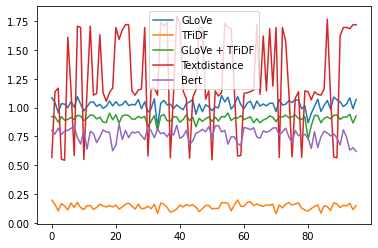

In [ ]:
plt.plot(GLoVe_Values,label = "GLoVe")
plt.plot(TFiDF_Values,label = "TFiDF")
plt.plot(GLoVe_TFiDF_Values , label = "GLoVe + TFiDF")
plt.plot(textdistance_values,label = "Textdistance")
plt.plot(bert_values,label = "Bert")
plt.legend()
plt.show()

##Error Analysis

In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
GLoVe_Values = {}
TFiDF_Values = {}
GLoVe_TFiDF_Values = {}
textdistance_values = {}
bert_values = {}
name_error = []
for i in range(len(file_names)):
  id = i
  try:
    GLoVe_Values[i] = GLoVe(id,job_requirement_path)
    TFiDF_Values[i] = TFiDF(id,job_requirement_path)
    GLoVe_TFiDF_Values[i] = GLoVe_TFiDF(id,job_requirement_path)
    textdistance_values[i] = textdistance(id, job_requirement_path)
    bert_values[i] = bert(id,job_requirement_path)
  except:
    name_error.append(i)
    continue

In [ ]:
print(name_error)

[18, 41, 70, 93, 116, 131, 163, 166, 172, 173, 174, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387

In [ ]:
#Adding glove and tfidf rankings
TFiDF_GLoVe_Values = TFiDF_Values.copy()
for key,value in GLoVe_Values.items():
  #print(key,value)
  TFiDF_GLoVe_Values[key] += value
  
TFiDF_GLoVe_rankings = list(dict(sorted(TFiDF_GLoVe_Values.items(), key=lambda x: x[1],reverse = True)).keys())

In [ ]:
GLoVe_Rankings = list(dict(sorted(GLoVe_Values.items(), key=lambda x: x[1],reverse = True)).keys())
TFiDF_Rankings = list(dict(sorted(TFiDF_Values.items(), key=lambda x: x[1],reverse = True)).keys())
GLoVe_TFiDF_Rankings = list(dict(sorted(TFiDF_Values.items(), key=lambda x: x[1],reverse = True)).keys())
textdistance_Rankings = list(dict(sorted(textdistance_values.items(), key=lambda x: x[1],reverse = True)).keys())
bert_Rankings = list(dict(sorted(bert_values.items(), key=lambda x: x[1],reverse = True)).keys())

In [ ]:
print(GLoVe_Rankings,'\n',TFiDF_Rankings,'\n',GLoVe_TFiDF_Rankings,'\n',textdistance_Rankings,'\n',bert_Rankings)

[55, 60, 8, 91, 57, 124, 151, 0, 97, 100, 33, 105, 185, 86, 132, 99, 79, 74, 187, 28, 46, 92, 143, 186, 114, 36, 89, 103, 80, 144, 196, 77, 159, 167, 24, 66, 129, 19, 64, 154, 176, 130, 160, 137, 21, 6, 194, 30, 56, 45, 94, 13, 148, 12, 108, 171, 1, 78, 134, 127, 188, 192, 115, 110, 147, 169, 63, 191, 72, 35, 71, 44, 126, 3, 195, 68, 106, 96, 48, 4, 168, 120, 76, 9, 15, 38, 26, 153, 61, 23, 50, 150, 37, 180, 40, 27, 59, 111, 75, 122, 157, 142, 88, 22, 121, 25, 177, 82, 161, 69, 164, 117, 20, 67, 17, 85, 136, 14, 112, 102, 95, 162, 51, 190, 11, 101, 53, 182, 7, 141, 181, 125, 42, 138, 5, 54, 152, 113, 140, 16, 39, 178, 62, 155, 98, 32, 128, 119, 29, 81, 65, 58, 90, 118, 43, 146, 135, 170, 149, 189, 139, 183, 145, 133, 52, 123, 184, 10, 107, 87, 179, 73, 109, 49, 31, 197, 2, 84, 158, 193, 47, 104, 156, 83, 34, 175, 165] 
 [185, 60, 0, 124, 114, 187, 64, 129, 151, 100, 63, 191, 8, 77, 55, 56, 91, 80, 137, 6, 35, 113, 25, 97, 167, 57, 176, 147, 159, 3, 162, 92, 79, 66, 178, 102, 72, 15, 28

In [ ]:
print('First:' ,GLoVe_Rankings[0],'\n',TFiDF_Rankings[0],'\n',bert_Rankings[0],'\n',textdistance_Rankings[0])
print('Last:' ,GLoVe_Rankings[-1],'\n',TFiDF_Rankings[-1],'\n',bert_Rankings[-1],'\n',textdistance_Rankings[-1])

First: 55 
 185 
 126 
 40
Last: 165 
 165 
 167 
 153


In [ ]:
id = 19

print(candidates['First Name'][id],candidates['Last Name'][id])
print(textdistance_Rankings.index(id),GLoVe_Rankings.index(id),TFiDF_Rankings.index(id))

Ehsan Matinfar
138 37 75


In [ ]:
print(RBO(textdistance_Rankings,TFiDF_Rankings))

0.2620615439998424


#Save Results

##Save Top Ten

In [ ]:
GLoVe_Top = {}
TFiDF_Top = {}
#GLoVe_TFiDF_Top = {} 
textdistance_Top = {}
bert_Top = {}
for i in range(10):
  GLoVe_Top[i+1]=   candidates['First Name'][GLoVe_Rankings[i]] + " " + candidates['Last Name'][GLoVe_Rankings[i]]
  #print(GLoVe_Rankings[i])
  TFiDF_Top[i+1]= candidates['First Name'][TFiDF_Rankings[i]] + " " + candidates['Last Name'][TFiDF_Rankings[i]]
  #GLoVe_TFiDF_Top[i] = candidates['First Name'][GLoVe_TFiDF_Rankings[i]],candidates['Last Name'][GLoVe_TFiDF_Rankings[i]]
  textdistance_Top[i+1] = candidates['First Name'][textdistance_Rankings[i]] +" " + candidates['Last Name'][textdistance_Rankings[i]]
  bert_Top[i+1] = candidates['First Name'][bert_Rankings[i]] +" " + candidates['Last Name'][bert_Rankings[i]]

save_to_file = {"GLoVe":GLoVe_Top,"TFiDF":TFiDF_Top,"Textdistance":textdistance_Top,"Bert":bert_Top}
print(save_to_file)

{'GLoVe': {1: 'Leo Moley', 2: 'Leana Mauricette', 3: 'Radhika Shukla', 4: 'Wang Yepu', 5: 'Ehsan Matinfar', 6: 'MerajUnnisa Begum', 7: 'Cynthia Liu', 8: 'Keegan Veazey', 9: 'Mohammed Zama', 10: 'Akshay Deshmukh'}, 'TFiDF': {1: 'Leo Moley', 2: 'Rajat Bhat', 3: 'Aakash Rathod', 4: 'Leana Mauricette', 5: 'Jai kiran Rajana', 6: 'MerajUnnisa Begum', 7: 'Rushal Gawali', 8: 'Mei-Chu Chen', 9: 'Shiva Abhishek Varma Penmetsa', 10: 'Atharva Saykhedkar'}, 'Textdistance': {1: 'Le Cai', 2: 'KEXI PI', 3: 'Xinze Yu', 4: 'Yutai Li', 5: 'Tu Nguyen', 6: 'Jeff Shen', 7: 'Wang Yepu', 8: 'Kedar S F', 9: 'Kevin Gong', 10: 'Jiazhi Jia'}, 'Bert': {1: 'Maulishree Gupta', 2: 'Giri Sai Sriram Mullangi', 3: 'Shrivatson Ramaratnam Giridharan', 4: 'Le Cai', 5: 'Sinchana Sulugodu Shashidhara', 6: 'Omid Halimi Milani', 7: 'Samrat Talukder', 8: 'Dhrumil Parekh', 9: 'Nima Razavi', 10: 'Wang Yepu'}}


In [ ]:
#with open("/content/drive/MyDrive/TopTen_Requirements.csv","w+") as file:
#with open("/content/drive/MyDrive/TopTen_Responsibilities.csv","w+") as file:
with open("/content/drive/MyDrive/TopTen.csv","w+") as file:  
  writer = csv.writer(file)
  writer.writerow(["Method\Columns"]+list(GLoVe_Top.keys()))
  for key ,value in save_to_file.items():
    writer.writerow([key]+list(value.values()))



##Save All

In [ ]:
Candidates = {}
for id in range(len(GLoVe_Rankings)):
  try:
    Candidate = candidates['First Name'][id] + ' ' + candidates['Last Name'][id]
    Candidates[Candidate] = [GLoVe_Rankings.index(id),TFiDF_Rankings.index(id),GLoVe_TFiDF_Rankings.index(id),textdistance_Rankings.index(id),bert_Rankings.index(id)]
  except:
    Candidates[Candidate] = [0,0,0,0,0]
    print(id,Candidate) 
print(Candidates) 

18 Diana Sîrbu
41 Letícia Neves dos Santos
70 Shruti Sorte
93 Yue (Cora) Mao
116 Jiatao Yuan
131 Michelle Zeng
163 Vaishnavi rao Kandula
166 Xiukui Ji
172 Zeynep Ebrar Çelikel
173 Zeynep Ebrar Çelikel
174 Abdullah Kasri
{'Aakash Rathod': [78, 2, 2, 176, 46], 'Aditi Gaikwad': [68, 44, 44, 130, 101], 'Ajay Iyer': [174, 165, 165, 106, 26], 'Akhila Reddy Jali': [87, 29, 29, 182, 109], 'Ali Bagheri Tirtashi': [137, 88, 88, 185, 57], 'Alonso Bautista Martin': [141, 161, 161, 93, 44], 'Aman Khosla': [69, 19, 19, 114, 30], 'Amogh Pai': [139, 113, 113, 169, 10], 'Anirudh Nair': [30, 12, 12, 34, 136], 'Arham Choraria': [50, 117, 117, 44, 166], 'Atalay Denknalbant': [143, 154, 154, 183, 48], 'Ben Kreitner': [97, 80, 80, 121, 178], 'Brinda Sarkar': [28, 74, 74, 35, 60], 'Catherine Donner': [45, 153, 153, 152, 96], 'Chengcheng Feng': [122, 116, 116, 143, 162], 'Chuqiao(Kathleen) Li': [81, 37, 37, 85, 129], 'Deema Alnuhait': [146, 87, 87, 137, 39], 'Deep Arvind Bambharoliya': [165, 104, 104, 167, 73

In [ ]:
#with open("/content/drive/MyDrive/Data_Analytics_Rankings_Requirements.csv","w+") as file:
#with open("/content/drive/MyDrive/Data_Analytics_Rankings_Responsibilities.csv","w+") as file:
with open("/content/drive/MyDrive/Data_Analytics_Rankings.csv","w+") as file: 
  writer = csv.writer(file)
  writer.writerow(['Name','GLoVe','TFiDF','GLoVe + TFiDF','Text Distance','Bert'])
  for key,value in Candidates.items():
    writer.writerow([key]+value)

##Save Ranking Comparision Scores

In [ ]:
rankings = {"Glove" : GLoVe_Rankings ,"TFiDF" : TFiDF_Rankings ,"Glove + TFiDF" : GLoVe_TFiDF_Rankings ,"Text Distance" : textdistance_Rankings ,"BeRT" : bert_Rankings}
scoring = {"Glove" : {} ,"TFiDF" : {},"Glove + TFiDF" : {} ,"Text Distance" : {} ,"BeRT" :{} }
for key1,value1 in rankings.items():
  for key2,value2 in rankings.items():
      scoring[key1][key2]  = {}
      #scoring[key1][key2]['kendall tau distance'] = kendalltau(value1, value2)
      #scoring[key1][key2]['bleu scores'] = sentence_bleu([value1], value2)
      #scoring[key1][key2] = sentence_bleu([value1], value2)
      #scoring[key1][key2]= kendalltau(value1, value2)
      scoring[key1][key2] = RBO(value1,value2)

In [ ]:
print(scoring)

{'Glove': {'Glove': 1.0, 'TFiDF': 4.803430137390974e-155, 'Glove + TFiDF': 4.803430137390974e-155, 'Text Distance': 4.039187183453553e-155, 'BeRT': 4.803430137390974e-155}, 'TFiDF': {'Glove': 4.803430137390974e-155, 'TFiDF': 1.0, 'Glove + TFiDF': 1.0, 'Text Distance': 1.821831989445342e-231, 'BeRT': 4.803430137390974e-155}, 'Glove + TFiDF': {'Glove': 4.803430137390974e-155, 'TFiDF': 1.0, 'Glove + TFiDF': 1.0, 'Text Distance': 1.821831989445342e-231, 'BeRT': 4.803430137390974e-155}, 'Text Distance': {'Glove': 4.039187183453553e-155, 'TFiDF': 1.821831989445342e-231, 'Glove + TFiDF': 1.821831989445342e-231, 'Text Distance': 1.0, 'BeRT': 4.039187183453553e-155}, 'BeRT': {'Glove': 4.803430137390974e-155, 'TFiDF': 4.803430137390974e-155, 'Glove + TFiDF': 4.803430137390974e-155, 'Text Distance': 4.039187183453553e-155, 'BeRT': 1.0}}


In [ ]:
with open('/content/drive/MyDrive/Results and Documentation/Bleu_Scores.csv','w+') as file:
  writer = csv.writer(file)
  writer.writerow(['','GLoVe','TFiDF','GLoVe + TFiDF','Text Distance','Bert'])
  for key, value in scoring.items():
      writer.writerow([key]+list(value.values()))


In [ ]:
with open('/content/drive/MyDrive/Results and Documentation/kendall_tau.csv','w+') as file:
  writer = csv.writer(file)
  writer.writerow(['','GLoVe','TFiDF','GLoVe + TFiDF','Text Distance','Bert'])
  for key, value in scoring.items():
      writer.writerow([key]+list(value.values()))

In [ ]:
with open('/content/drive/MyDrive/Results and Documentation/RBO.csv','w+') as file:
  writer = csv.writer(file)
  writer.writerow(['','GLoVe','TFiDF','GLoVe + TFiDF','Text Distance','Bert'])
  for key, value in scoring.items():
      writer.writerow([key]+list(value.values()))

##Save Timing Comparision

In [ ]:
with open('/content/drive/MyDrive/Results and Documentation/methods_timings.csv','w+') as file:
  writer = csv.writer(file)
  writer.writerow(['','GLoVe','TFiDF','GLoVe + TFiDF','Text Distance','Bert'])
  for i in range(test):
    writer.writerow([i,GLoVe_time[i],TFiDF_time[i],GLoVe_TFiDF_time[i],textdistance_time[i],bert_time[i]])    
  writer.writerow(["Total",sum(GLoVe_time),sum(TFiDF_time),sum(GLoVe_TFiDF_time),sum(textdistance_time),sum(bert_time)])    
